# # Introduction to Logistic Regression in PyTorch


In this Notebook we will be building a Neural Network on the MNIST dataset and implementing the logistic regression model.We will be including the forward and backward pass along with the loss function and optimizers.After training the model we will evaluate how we did and visualize what we've learned.

Imports of the packages we will be using.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

### MNIST Dataset

The MNIST database (Modified National Institute of Standards and Technology database is a large database of handwritten digits that is commonly used for training various image processing systems.The MNIST database contains 60,000 training images and 10,000 testing images.

![MNIST](Figures/MnistExamples.png)

The first and foremost step in machine learning is preparing the data , this involves downloading, organzing, shuffling, processing the data so it can be fed into the model.
The torchvision package makes this easy for us by implementing many of these , allowing us to put to use these datasets in only a few lines of code.


In [5]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [6]:
print("Number of MNIST Training Examples: {}".format(len(mnist_train)))
print("Number of MNIST Testing Exmaples: {}".format(len(mnist_test)))

Number of MNIST Training Examples: 60000
Number of MNIST Testing Exmaples: 10000


As expected 60,000 of the MNIST examples are in the training set while the rest 10,000 are in the testing set. We added the transform ToTensor() to convert the input data from a PIL type into a PyTorch Tensor. Tensors are the input type that we feed into our model.

Checking a random image from our train set. The shape of ourimage tensor returns to be something 3-Dimensional , To visualize this we need to remove the 1 which indicates 


Default Image Shape torch.Size([1, 28, 28])
Reshaped Image Shape torch.Size([28, 28])
The label for this Image 0


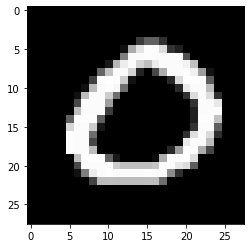

In [20]:
image , label = mnist_train[435]
print("Default Image Shape {}".format(image.shape))
image=image.reshape([28,28])
print("Reshaped Image Shape {}".format(image.shape))
plt.imshow(image, cmap="gray")
print("The label for this Image {}".format(label))

While we could directly work with the date using `torchvision.dataset` we use `Data Loader` which makes it easier for shuffling and batching.

In [21]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

### Logistic Regression Model